In [1]:
import os
import numpy as np
import sparse
import h5py
from scipy.io import savemat


In [2]:
project_path = "../"
data_path = os.path.join(project_path, "Data/raw_data")

In [3]:
path = os.path.join(data_path, "DTI_voxel_network.mat")
xyz = h5py.File(path, "r")["dti_xyz2"][:]
coordinate_min = np.empty(3, dtype=np.int64)
coordinate_max = np.empty(3, dtype=np.int64)
for i in range(xyz.shape[1]):
    print(f"{i}th coordinate: min {xyz[:, i].min()}, max {xyz[:, i].max()}")
    coordinate_min[i] = xyz[:, i].min()
    coordinate_max[i] = xyz[:, i].max()

0th coordinate: min -66.0, max 63.0
1th coordinate: min -105.0, max 72.0
2th coordinate: min -45.0, max 81.0


## show lfp

vmean shape: (1600, 22703)


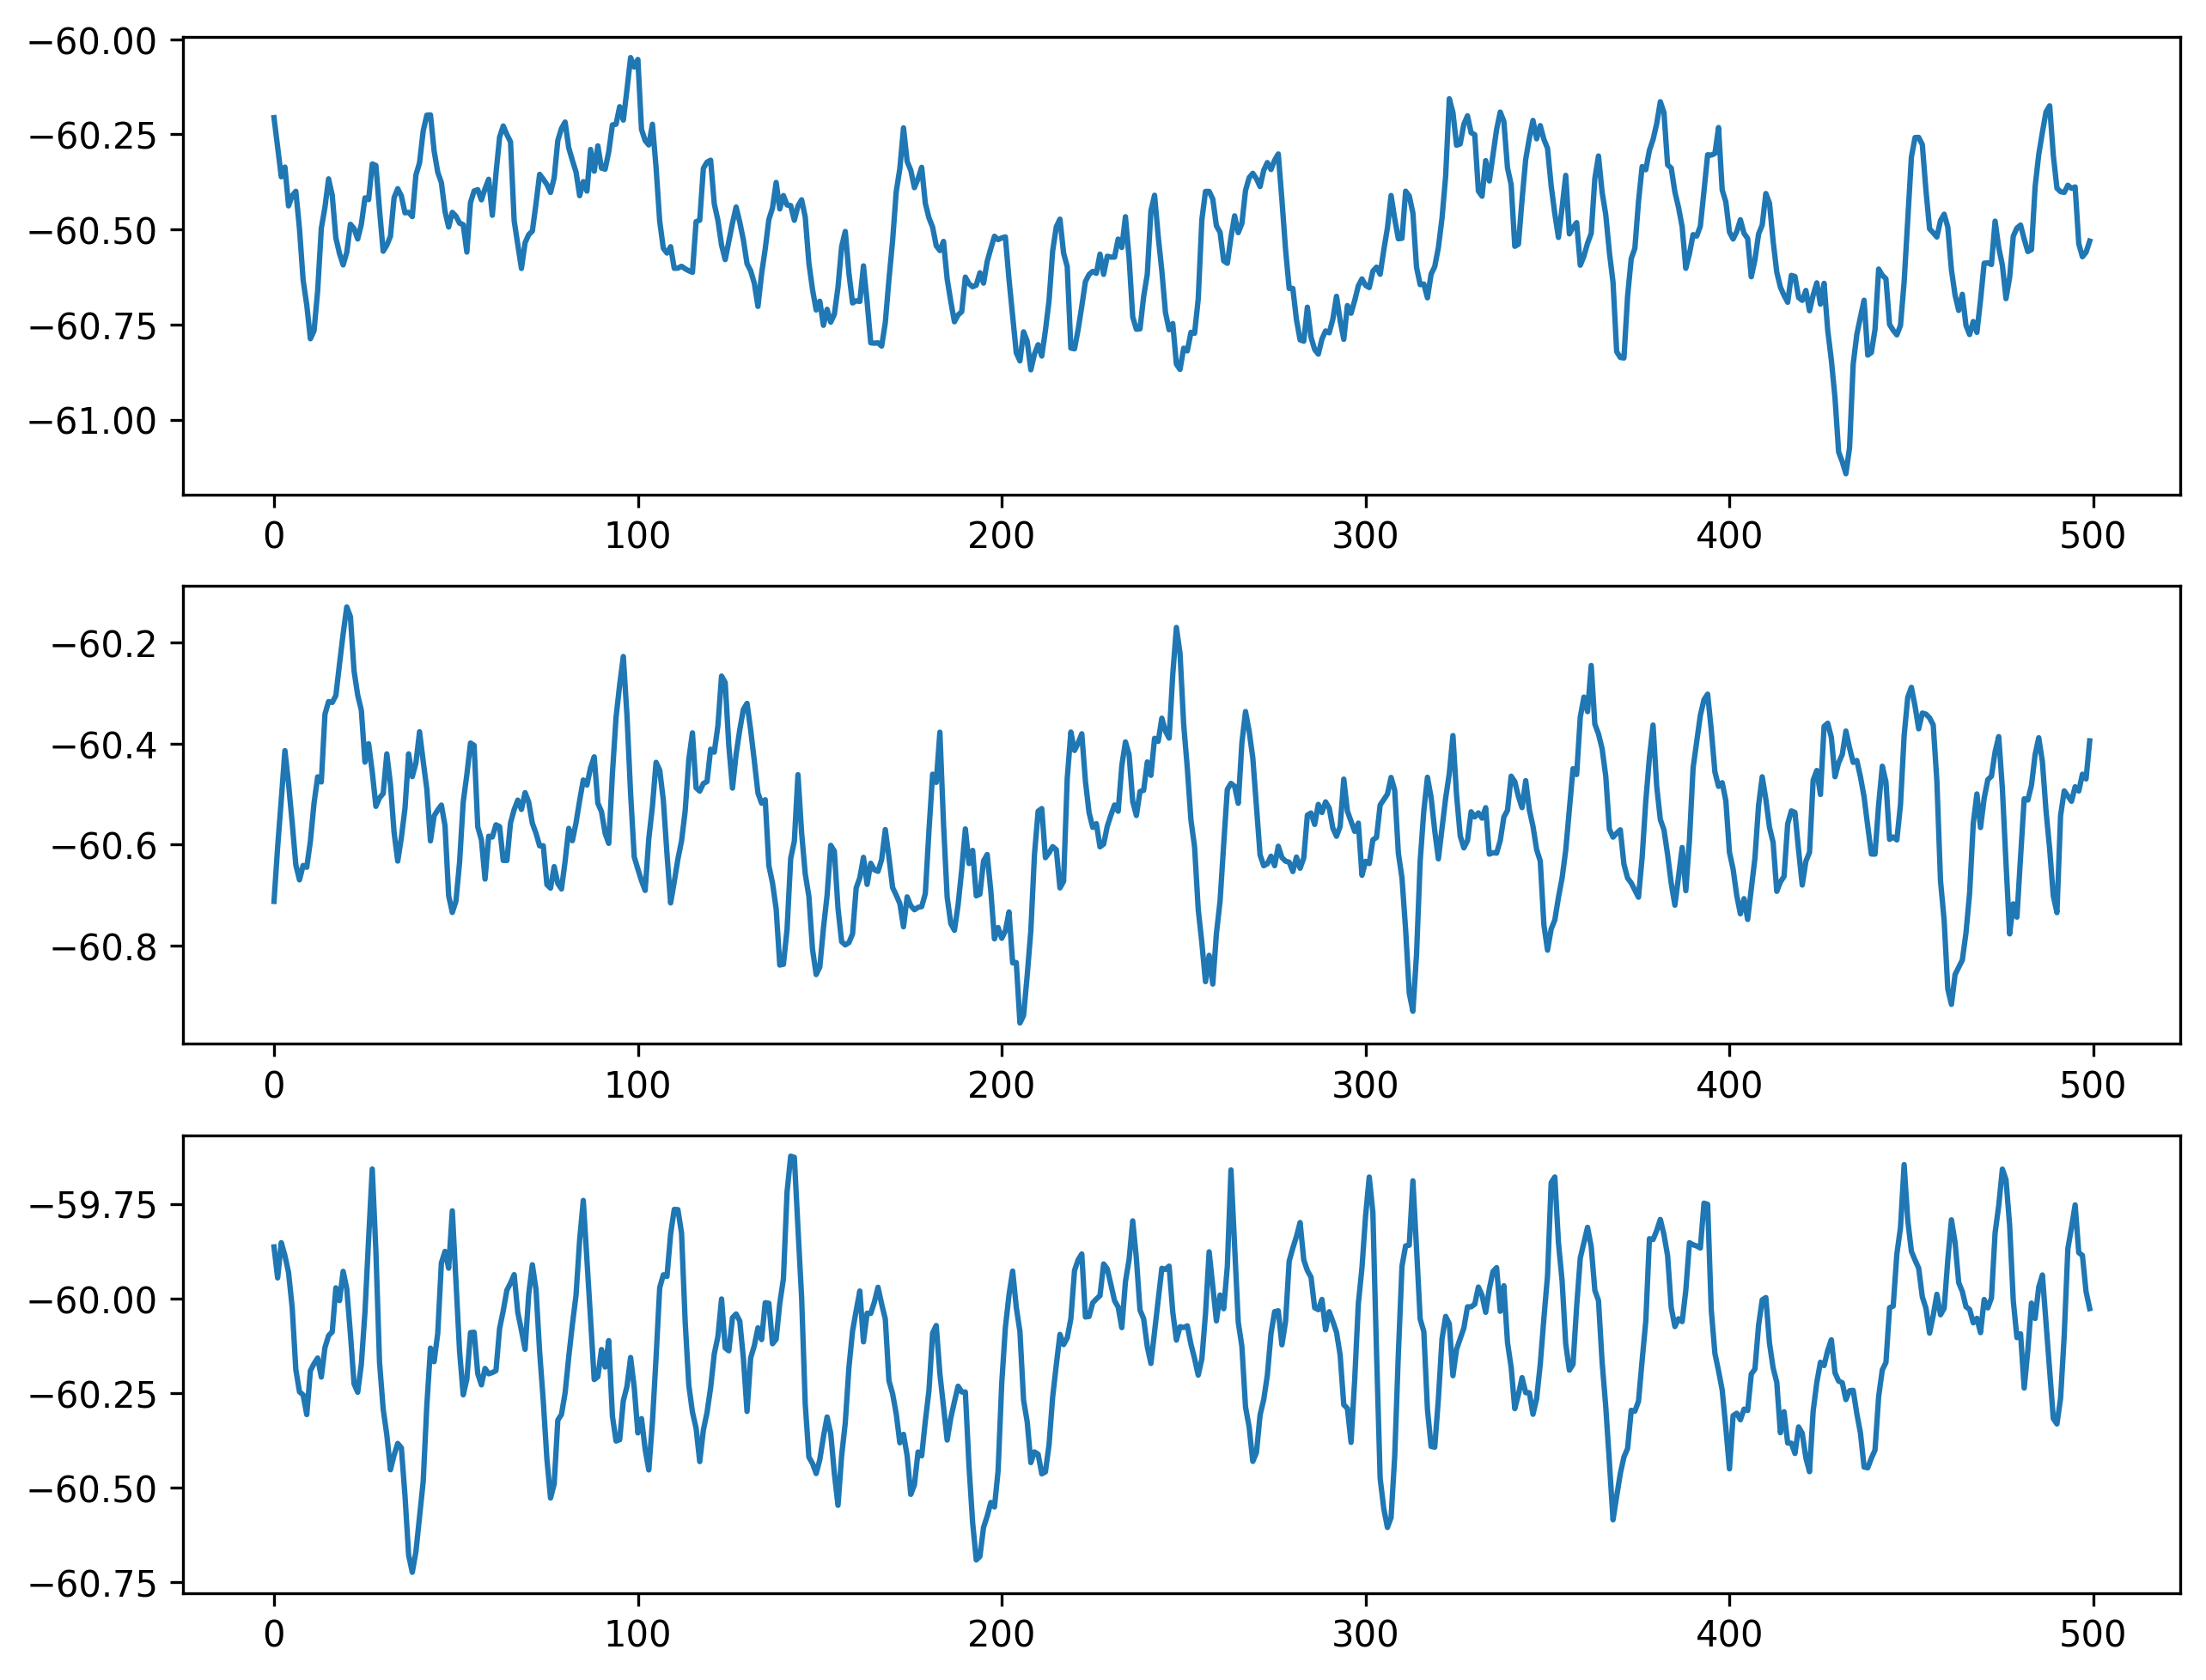

In [4]:
import matplotlib.pyplot as plt
vmean = np.load("../Data/raw_data/vmean.npy")
print(f"vmean shape: {vmean.shape}")
invert_index = np.load(os.path.join(data_path, "invert_index.npy"))
vmean = vmean[:, invert_index]
vmean_ = vmean[700:1200, :]
fig, ax = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
ax = ax.flatten()
ax[0].plot(vmean_[:, 2980])
ax[1].plot(vmean_[:, 2981])
ax[2].plot(vmean_[:, 10030])
plt.show()


## Spectrum


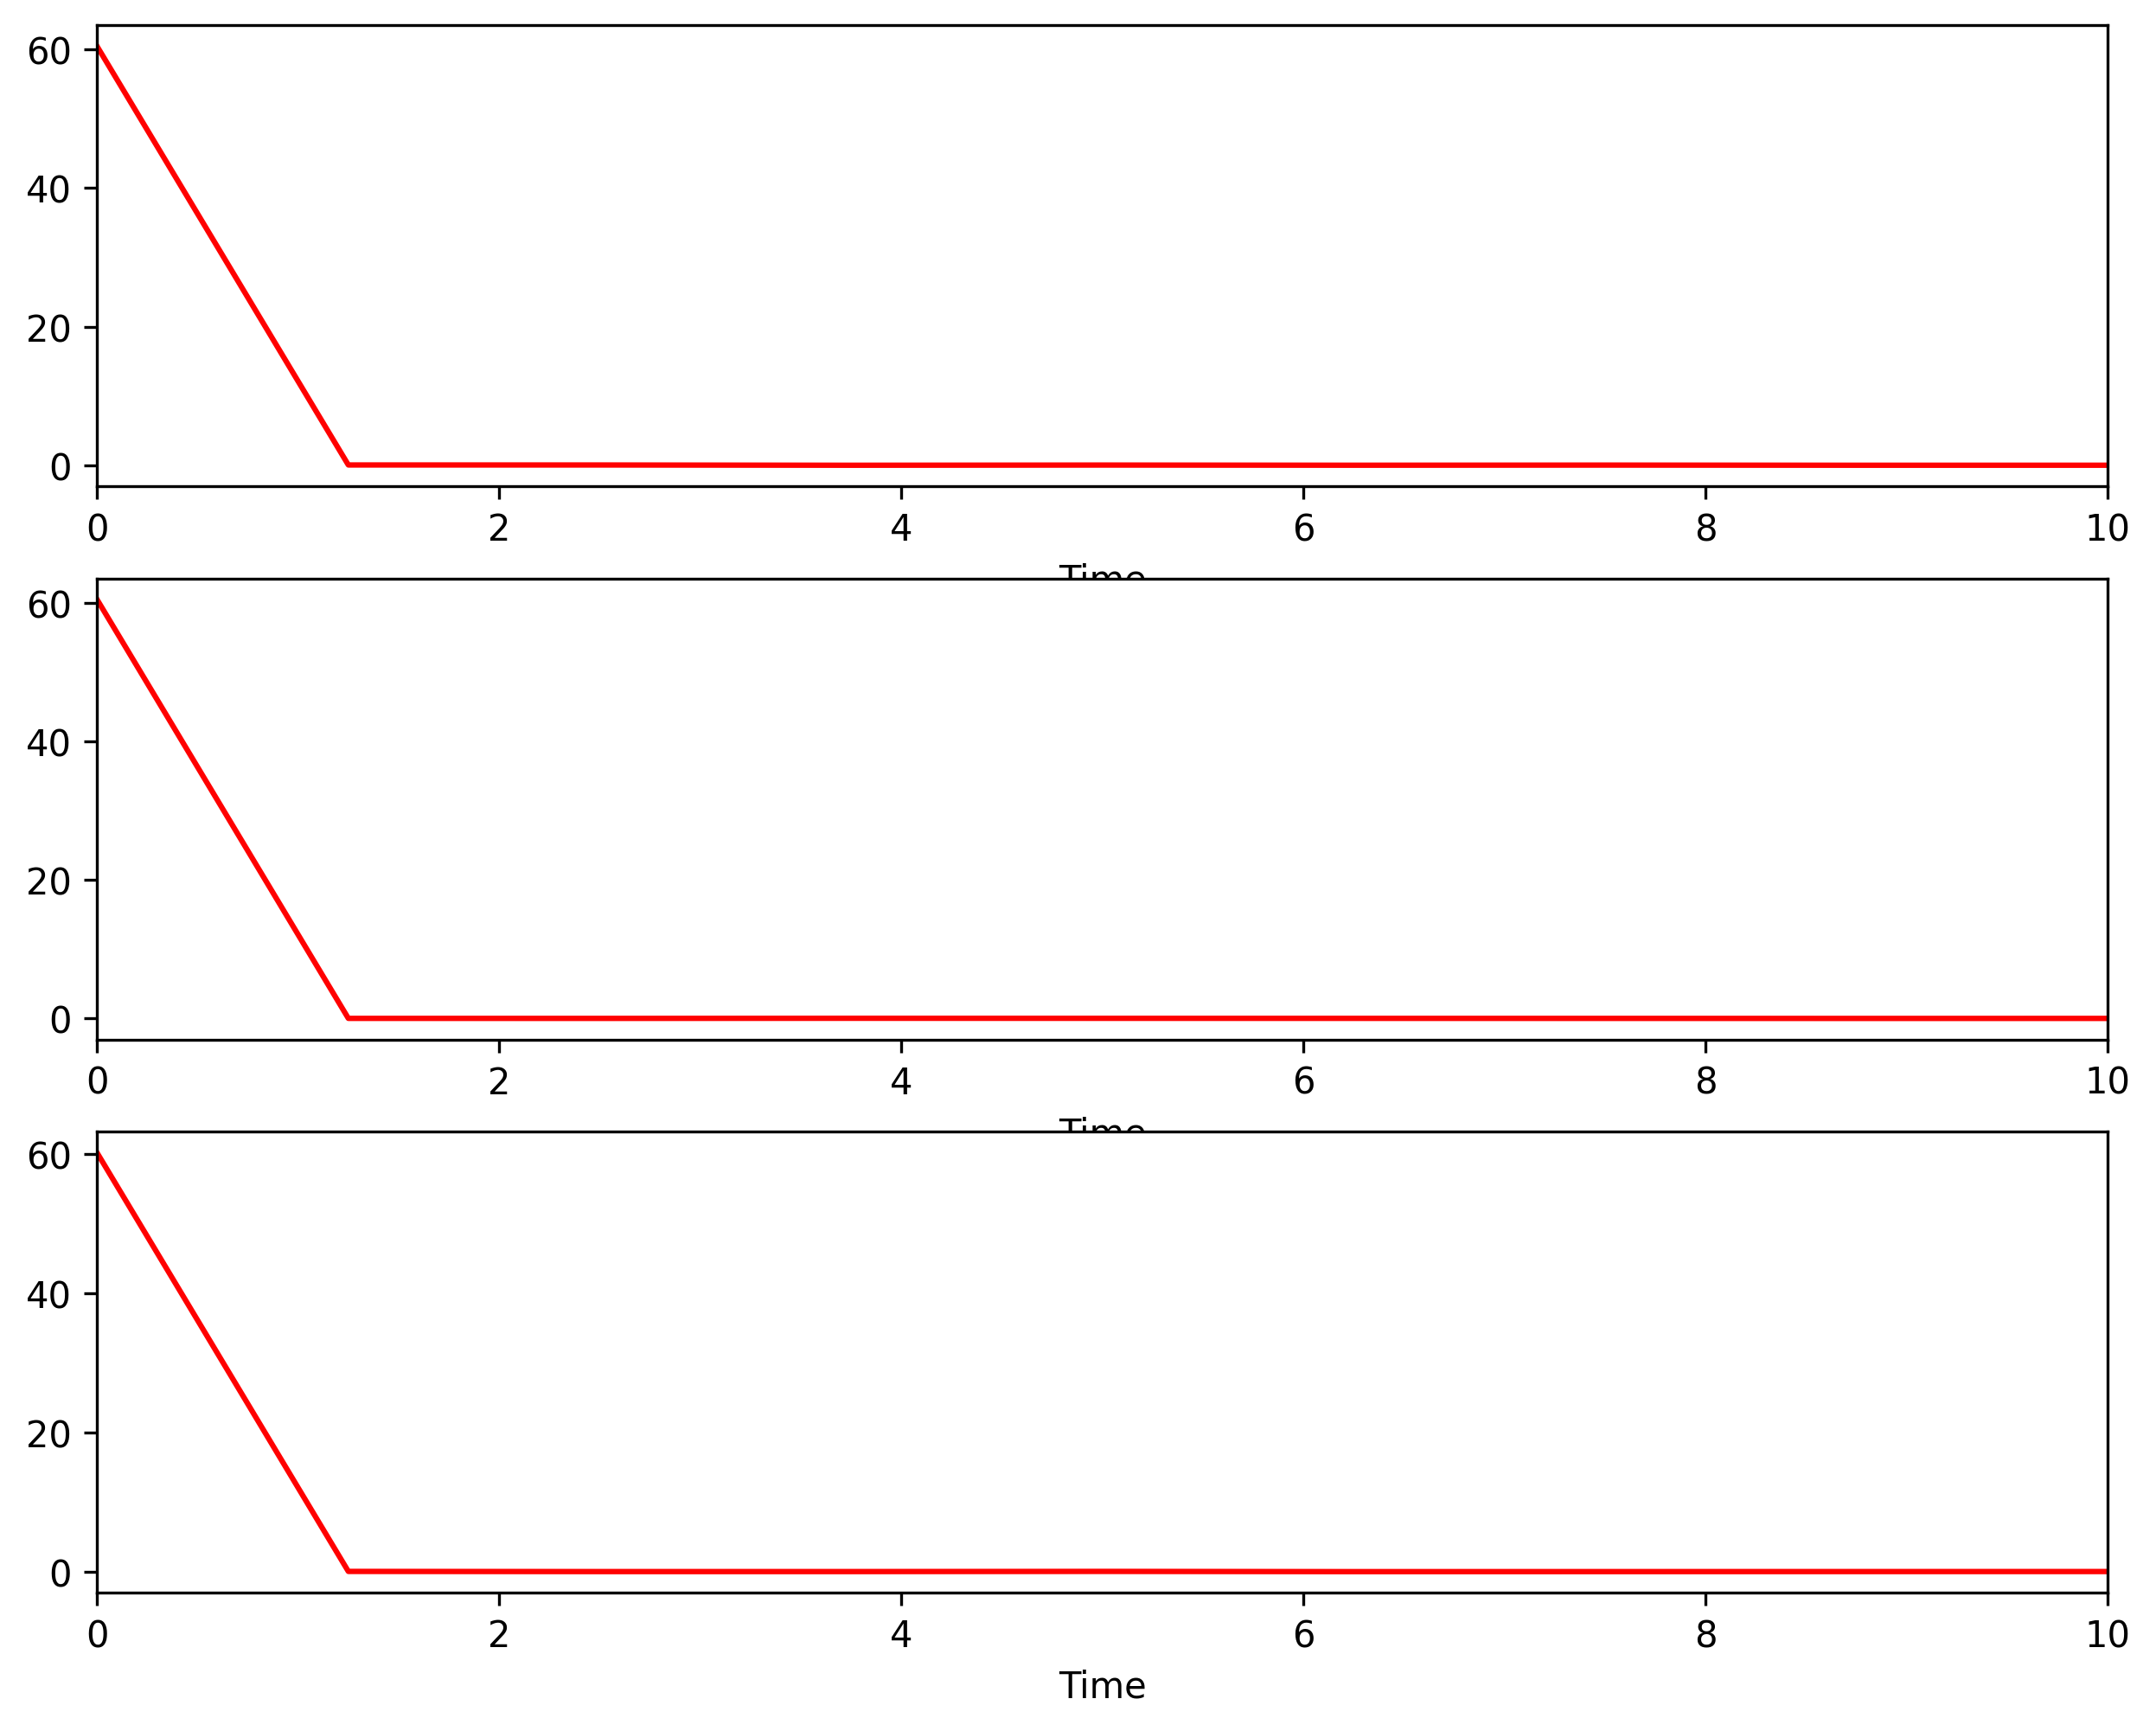

In [5]:
seed_list = np.array([2980, 2981, 10030], dtype=np.int64)
fig, ax = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
ax = ax.flatten()
for idx, seed in enumerate(seed_list):
    data = vmean[800:, seed]
    Fs = 1000.0
    Ts = 1.0 / Fs
    t = np.arange(len(data)) / Fs

    n = len(data)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    frq = frq[range(int(n / 2))]

    Y = np.fft.fft(data) / n
    Y = Y[range(int(n / 2))]

    ax[idx].plot(frq, abs(Y), 'r')
    ax[idx].set_xlim((0, 10))
    ax[idx].set_xlabel('Freq (Hz)')
    ax[idx].set_xlabel('Time')

plt.show()


## Moving average in 10ms wnidow

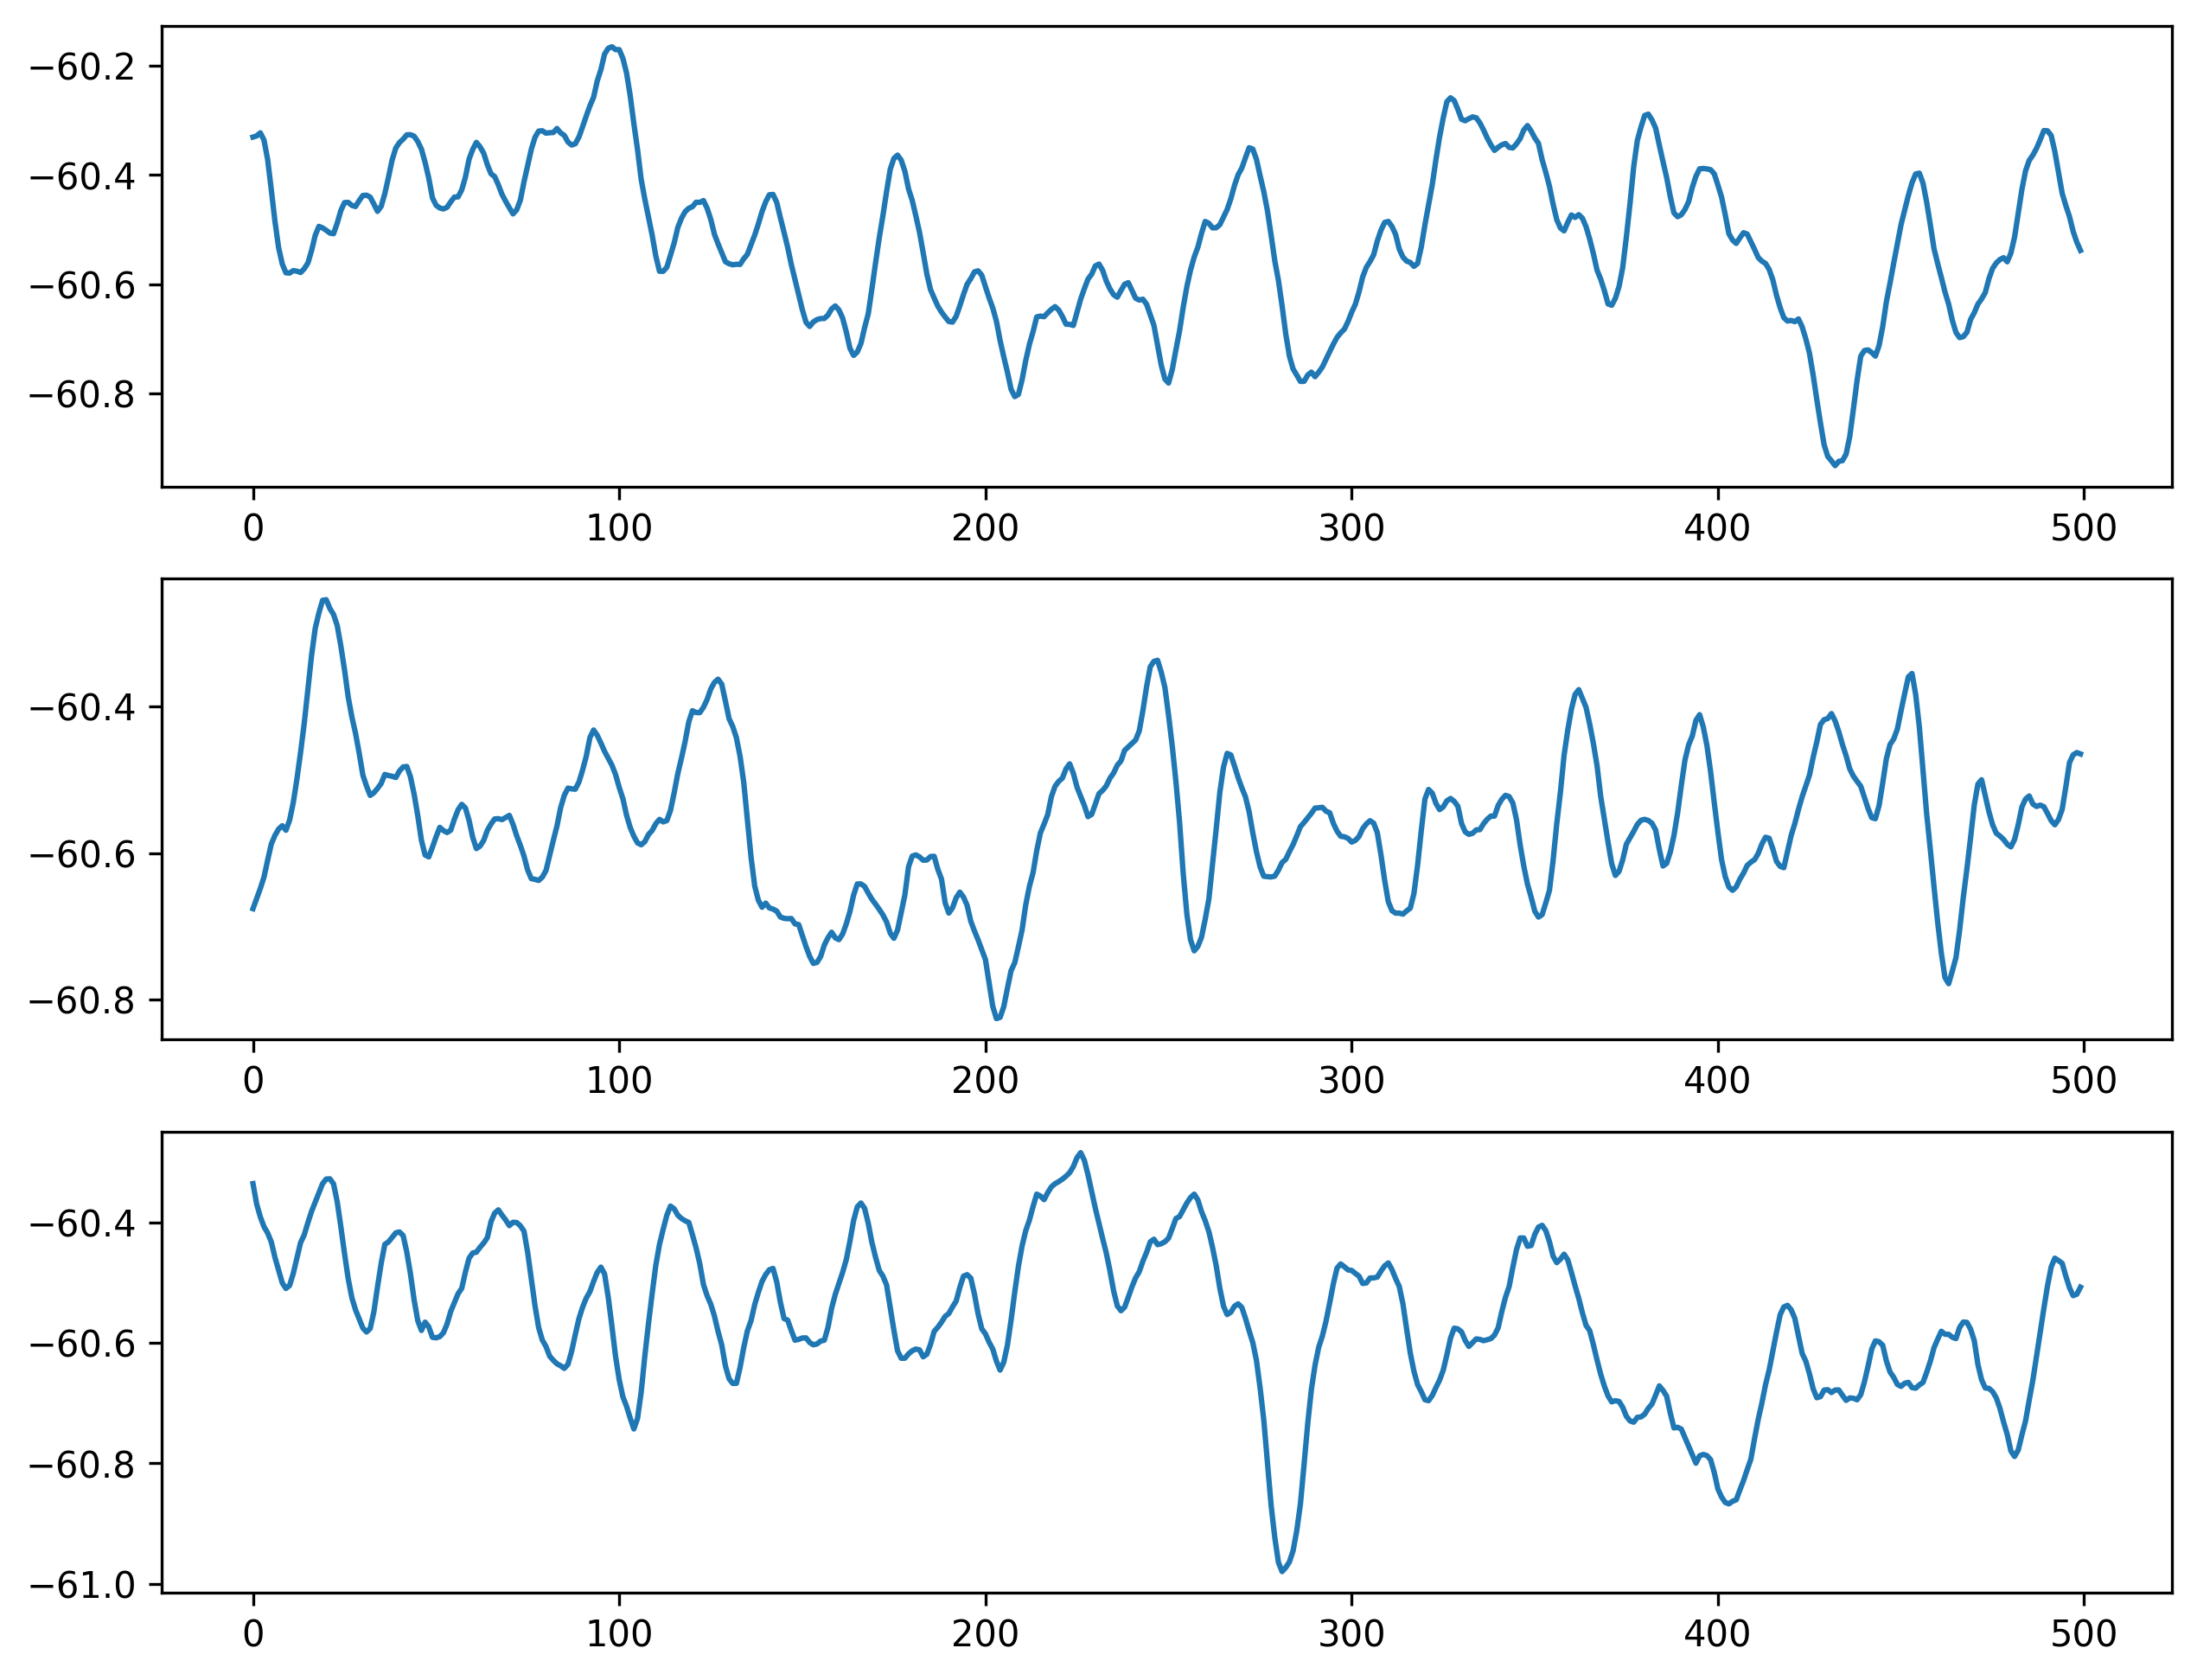

In [5]:
def np_move_avg(a, n=10, mode="same"):
    tmp = []
    for i in range(a.shape[1]):
        tmp.append(np.convolve(a[:, i], np.ones((n,)) / n, mode=mode))
    return np.stack(tmp, axis=1)
vmean_avg = np_move_avg(vmean, n=10)
vmean_ = vmean_avg[700:1200, :]
fig, ax = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
ax = ax.flatten()
ax[0].plot(vmean_[:, 2980])
ax[1].plot(vmean_[:, 2981])
ax[2].plot(vmean_[:, 14513])
plt.show()


## moving average and then downsample


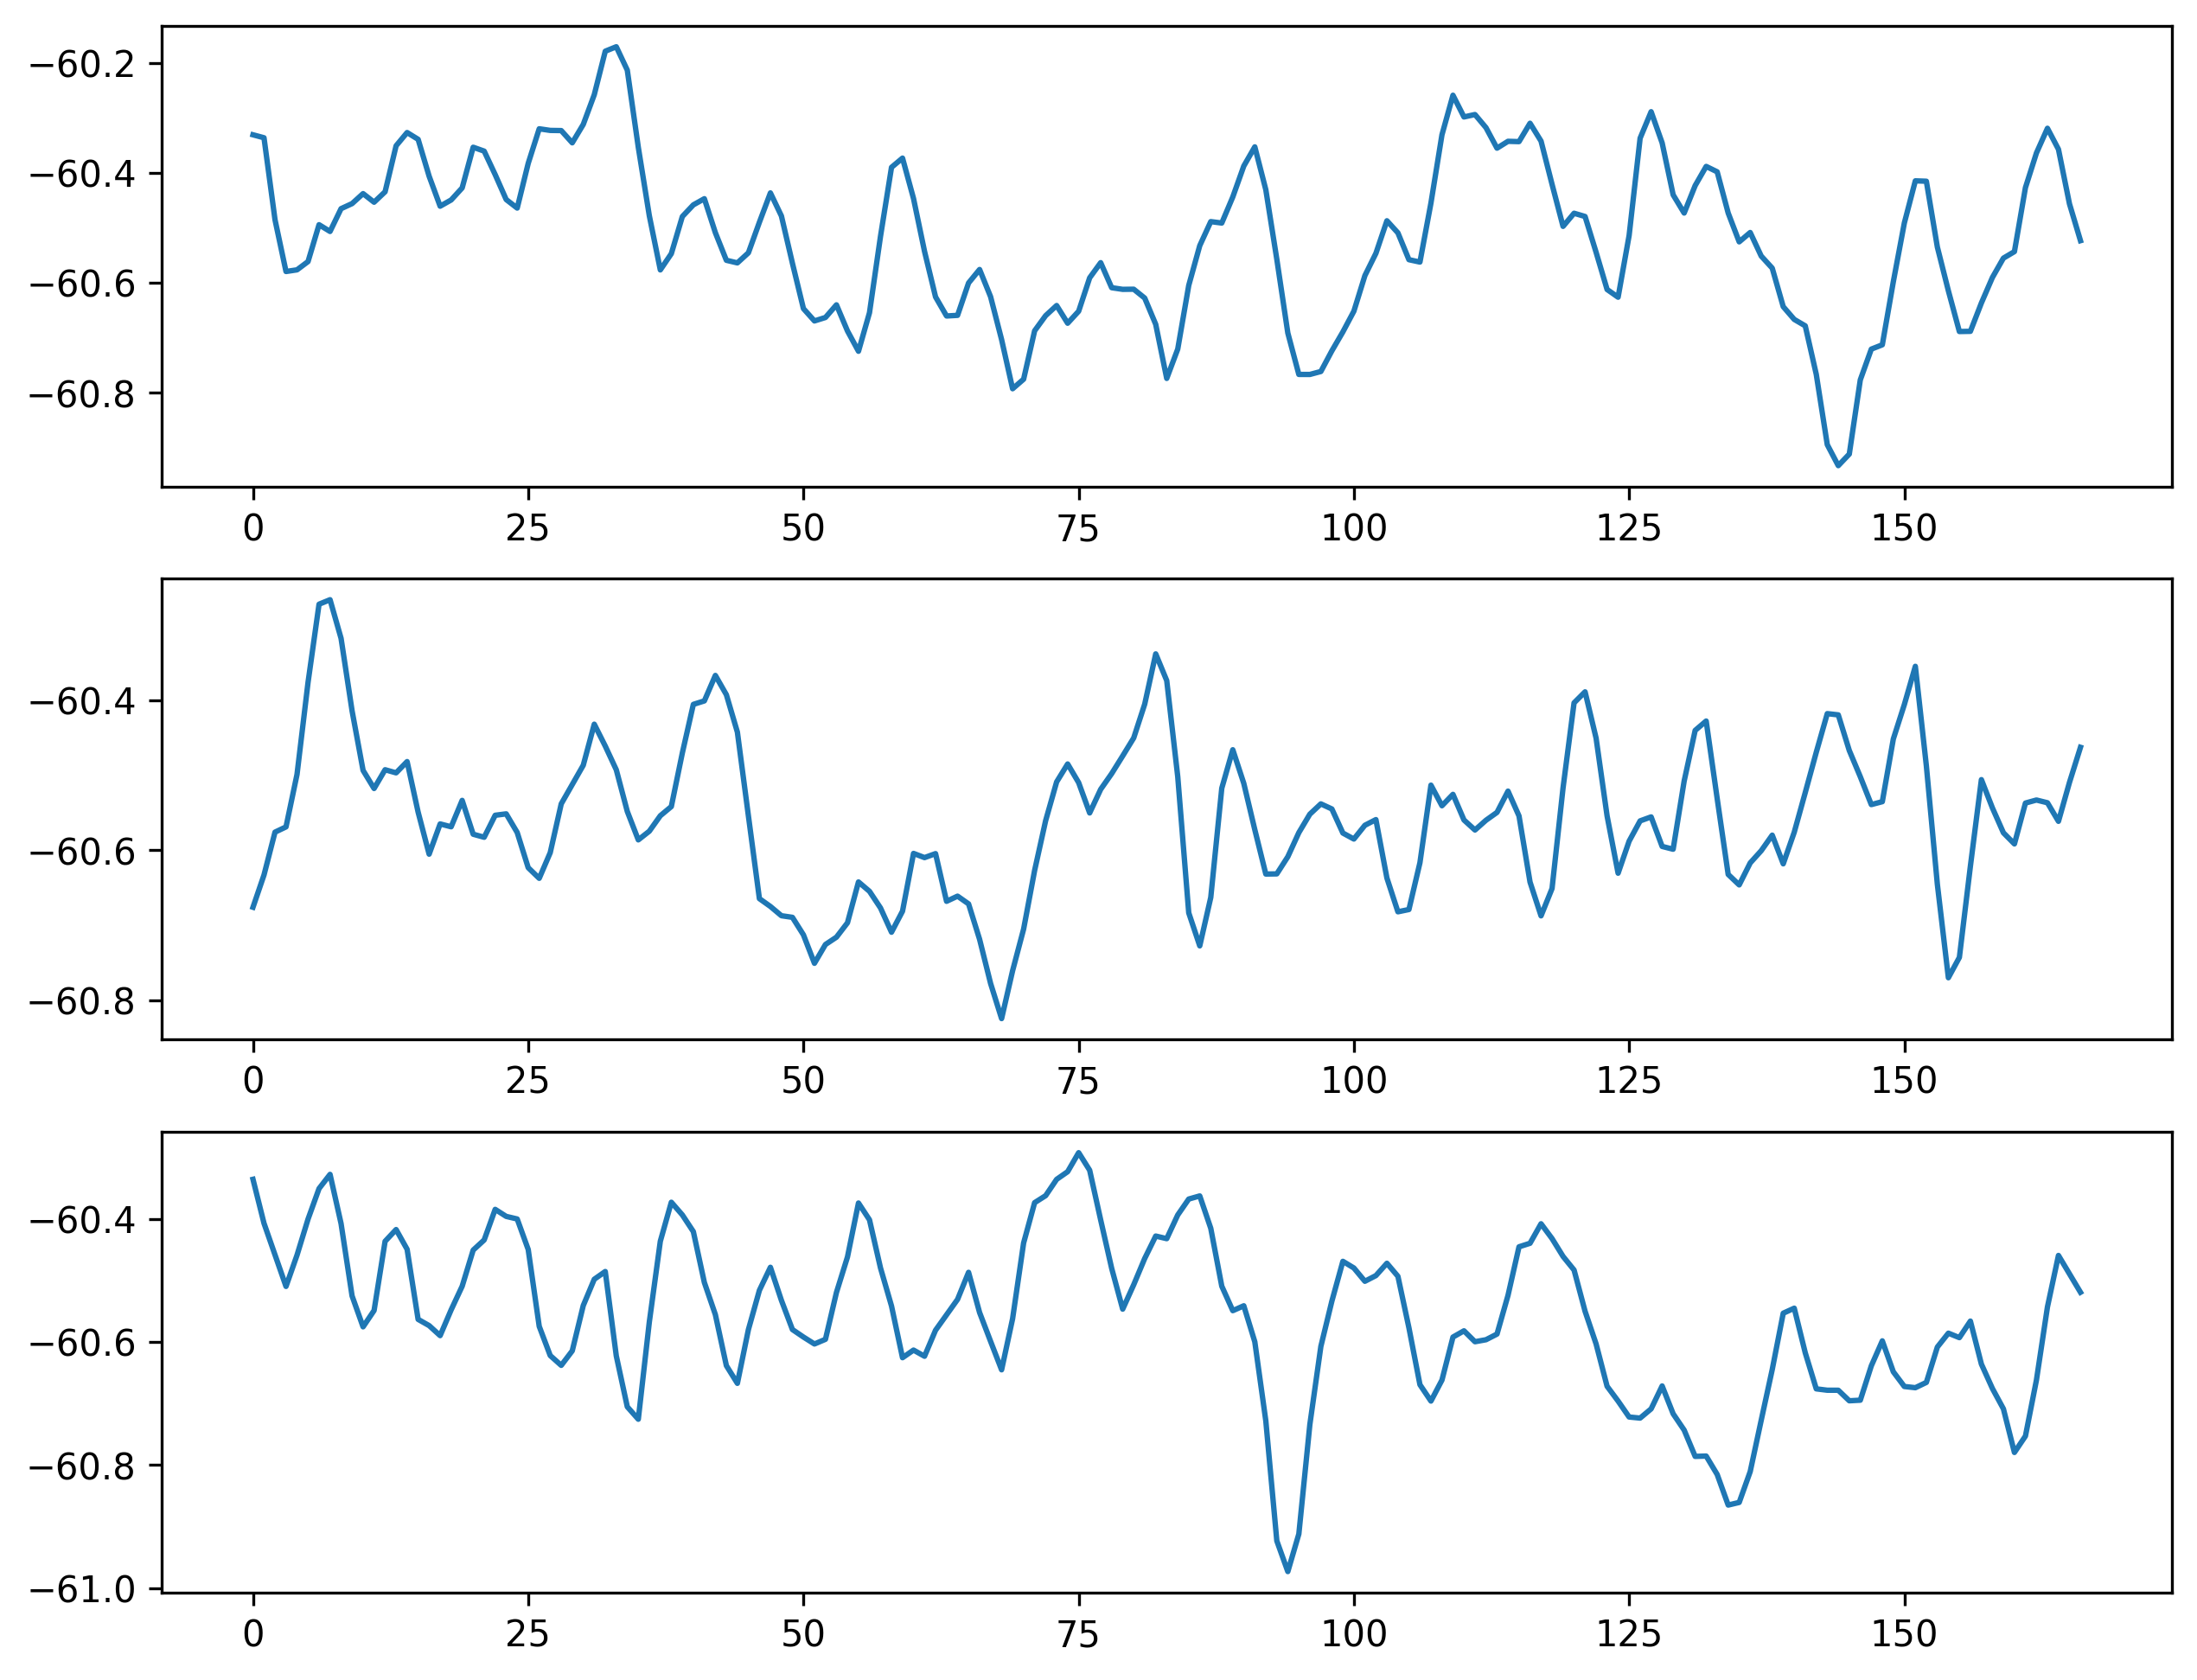

In [6]:
vmean_ = vmean_avg[700:1200, :]
vmean_ = vmean_[::3, :]
fig, ax = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
ax = ax.flatten()
ax[0].plot(vmean_[:, 2980])
ax[1].plot(vmean_[:, 2981])
ax[2].plot(vmean_[:, 14513])
plt.show()

In [7]:
xyz_new = np.ceil(xyz / 2).astype(np.int64)
xyz_new = xyz_new + np.array([33, 52, 22])
for i in range(xyz_new.shape[1]):
    print(f"{i}th coordinate: min {xyz_new[:, i].min()}, max {xyz_new[:, i].max()}")
    coordinate_min[i] = xyz_new[:, i].min()
    coordinate_max[i] = xyz_new[:, i].max()
xyz_new = xyz_new.astype(np.int64).T  #
t = vmean_.shape[0]# (3, 22703)
shape = [coordinate_max[0] + 1, coordinate_max[1] + 1, coordinate_max[2] + 1, t]
coords = np.empty([4, vmean_.shape[1] * vmean_.shape[0]], dtype=np.int64)
coords[(0, 1, 2), :] = np.broadcast_to(xyz_new[:, :, None], (xyz_new.shape[0], xyz_new.shape[1], t)).reshape(
    (3, -1))
coords[3, :] = np.broadcast_to(np.arange(t, dtype=np.int64), (vmean_.shape[1], t)).reshape(-1)
data = vmean_.T.reshape(-1)
vmean_with_coordinate_sparse = sparse.COO(coords=coords, data=data, shape=shape)
sparse.save_npz(os.path.join(data_path, "vmean_with_coordinate_sparse.npz"), vmean_with_coordinate_sparse)

0th coordinate: min 0, max 65
1th coordinate: min 0, max 88
2th coordinate: min 0, max 63


vmean_with_coordinate shape: (66, 89, 64, 167)
0.0 -64.55201561012599


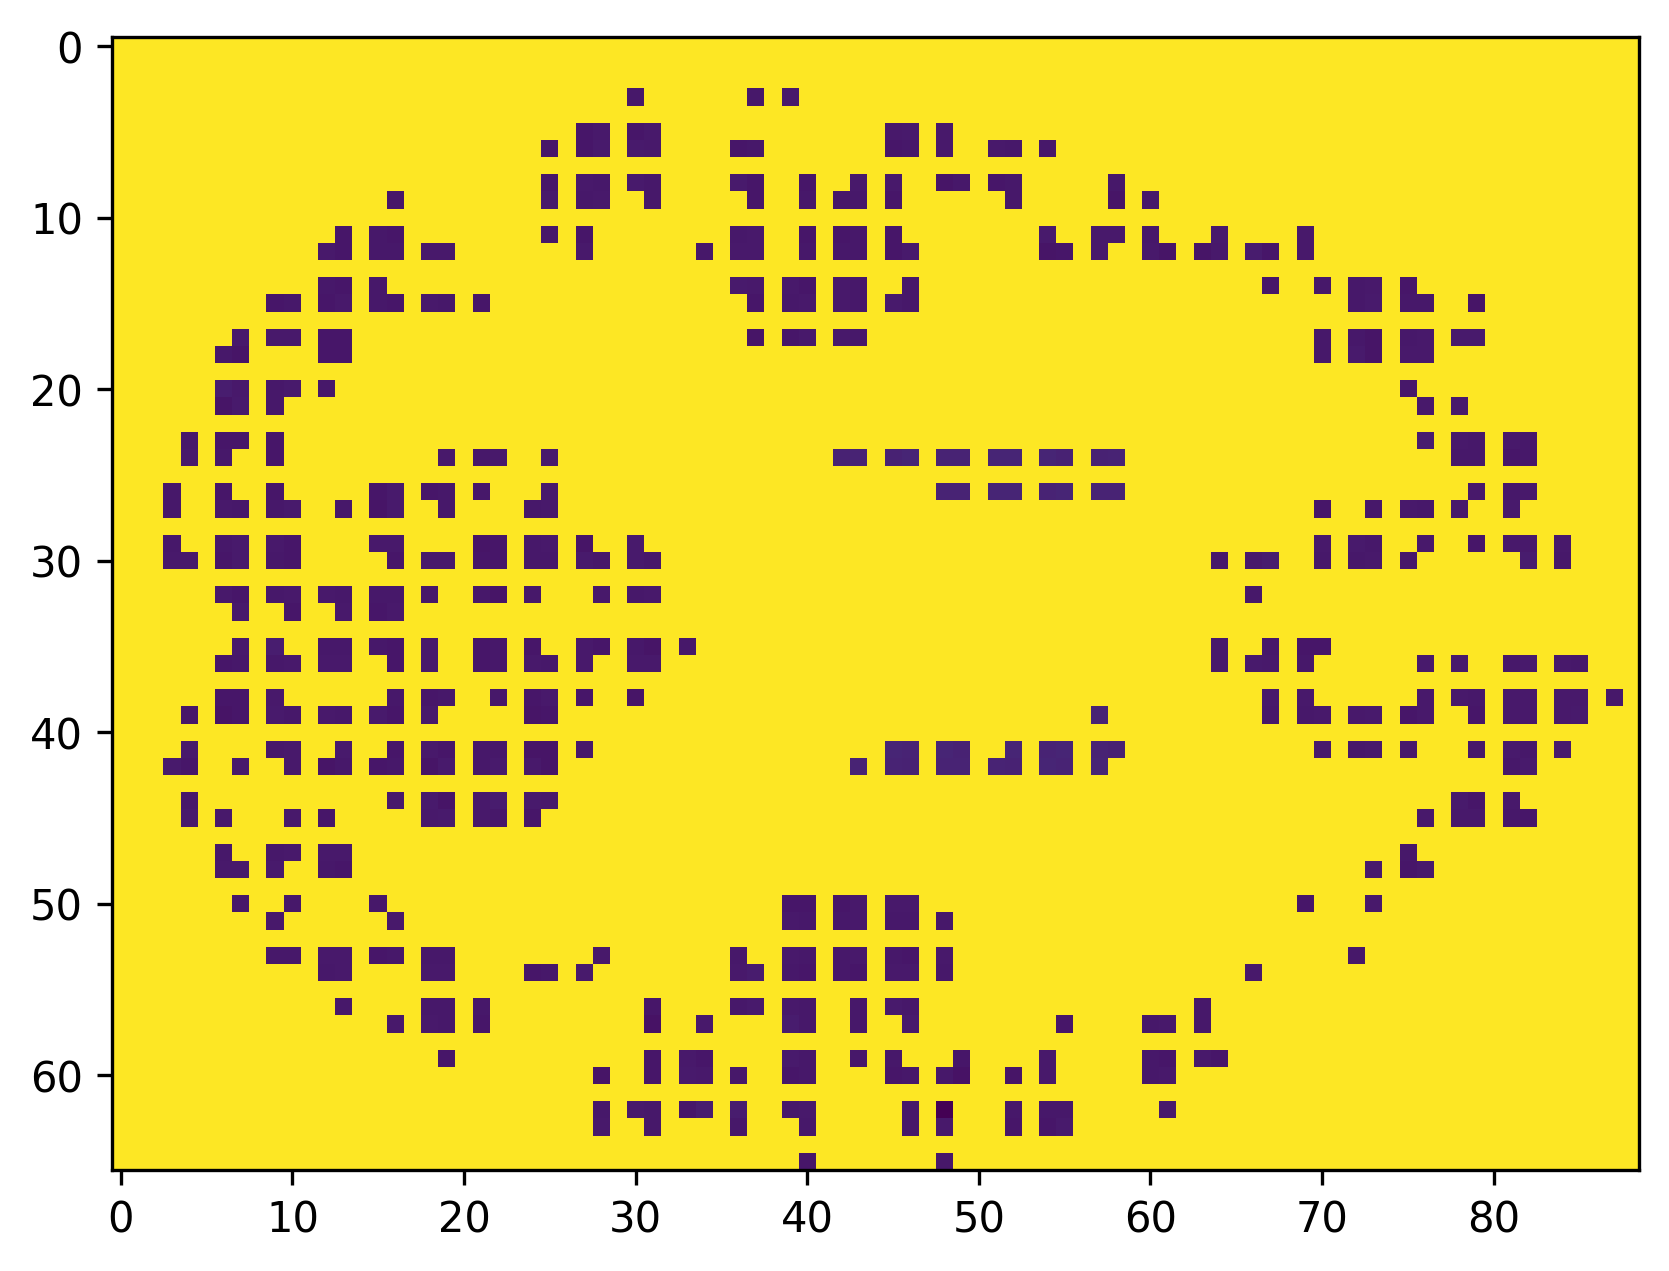

In [8]:
vmean_with_coordinate = vmean_with_coordinate_sparse.todense()
savemat(os.path.join(data_path, "vmean_with_coordinate.mat"), mdict={"brain_image":vmean_with_coordinate})
print(f"vmean_with_coordinate shape: {vmean_with_coordinate.shape}")
fig = plt.figure(figsize=(8, 5), dpi=300)
print(vmean_with_coordinate[:,  :, 33, 20].max(), vmean_with_coordinate[:,  :, 33, 20].min())
fig.gca().imshow(vmean_with_coordinate[:,  :, 33, 20])
plt.show()

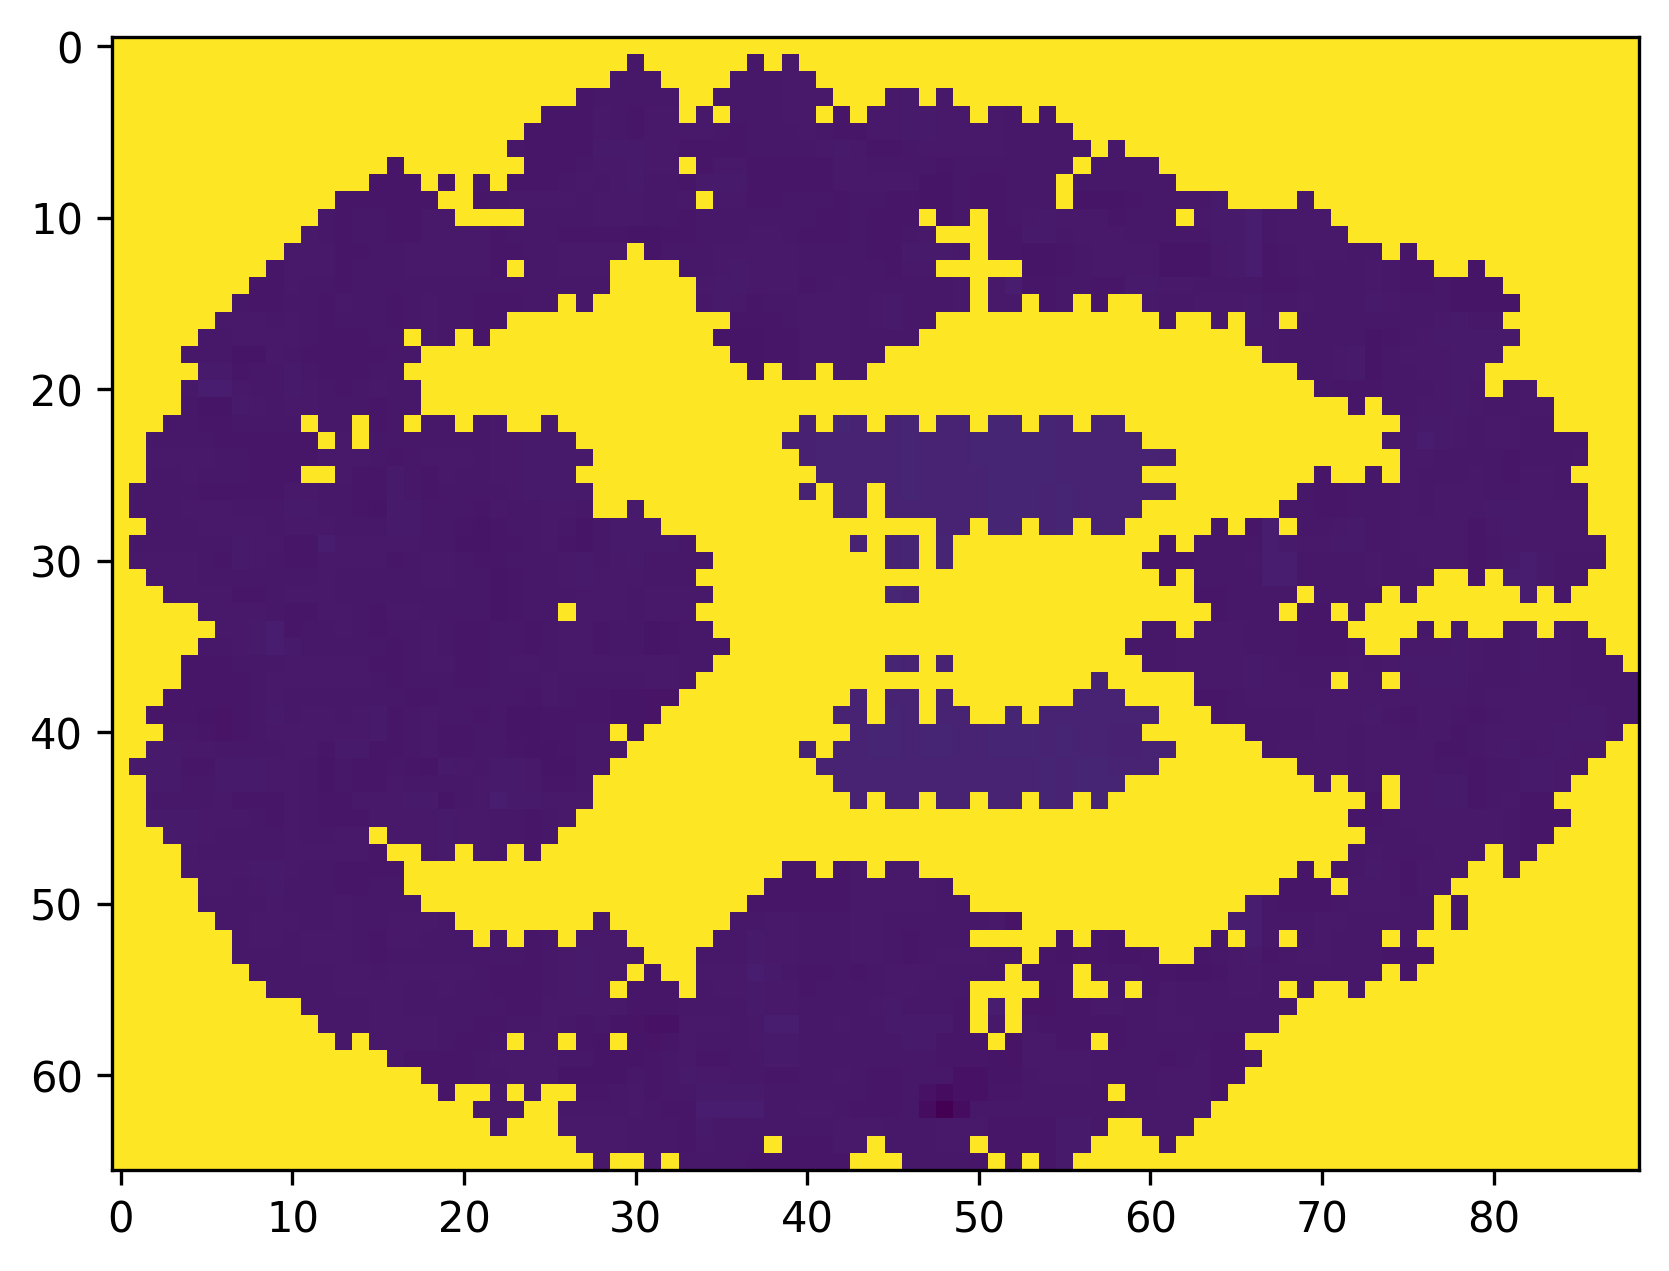

In [14]:
from scipy.io import loadmat
vmean_with_coordinate_interpolate = loadmat(os.path.join(data_path, "vmean_with_coordinate_interpolated2.mat"))
interpolate_brain_image = vmean_with_coordinate_interpolate["interpolate_brain_image"]
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(interpolate_brain_image[:,:, 33, 20])
plt.show()


In [ ]:
from scipy.interpolate import interpn
xyz = xyz + np.array([66, 105, 45])
for i in range(xyz.shape[1]):
    print(f"{i}th coordinate: min {xyz[:, i].min()}, max {xyz[:, i].max()}")
    coordinate_min[i] = xyz[:, i].min()
    coordinate_max[i] = xyz[:, i].max()

shape = [coordinate_max[0] + 1, coordinate_max[1] + 1, coordinate_max[2] + 1, t]
coords = np.empty([3, vmean_.shape[1]], dtype=np.int64)
coords[(0, 1, 2), :] = np.broadcast_to(xyz[:, :, None], (xyz.shape[0], xyz.shape[1], t)).reshape(
    (3, -1))
coords[3, :] = np.broadcast_to(np.arange(t, dtype=np.int64), (vmean_.shape[1], t)).reshape(-1)
data = vmean_.T.reshape(-1)
vmean_with_coordinate_sparse = sparse.COO(coords=coords, data=data, shape=shape)

x = np.arange(coordinate_min[0], coordinate_max[0]+1)
y = np.arange(coordinate_min[1], coordinate_max[1]+1)
z = np.arange(coordinate_min[2], coordinate_max[2]+1)
points = (x, y, z)
values = np.zeros(())
values = fr800_with_coordinate_sparse.todense()
xi = np.stack(np.meshgrid(x, y, z, t), axis=-1).reshape((-4, 4))
point = interpn(points, values, xi)
point = point.reshape(shape)
savemat("fr800_with_coordinate_interpolated_new.mat", mdict={"interpolate_brain_image": point})#%%
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(point[:,:, 33, 20])
plt.show()
